In [1]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import Dataset, DataLoader
from utils.data_loader import load_dataset
import torch

train_data, train_labels, test_data, test_labels = load_dataset("mnist", flatten=False, binarize=True, with_targets=True)

In [3]:
# set parameters for dataloader
device = "cpu"
use_cuda = False
if torch.cuda.is_available():
    device = "cuda"
    use_cuda = True
batch_size = 512

In [4]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x)
        self.y = torch.tensor(y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
train_dataset = MyDataset(train_data, train_labels)
test_dataset = MyDataset(test_data, test_labels)

if use_cuda:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=3)
    valloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=3)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                            )
    valloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            )

пока сделаем тупую модель, которая будет работать с плоскими картинками

In [5]:
%load_ext autoreload
%autoreload 2

import bayess
import bayess.nn as bnn
import torch.nn as nn
import bayess.resulting_types
from bayess.training import train_model

model_dimentions = [28 * 28, 1024, 1024, 10]
epochs = 20
n_samples = 8

reparametrization_fabric = bnn.reparametrizations.NormalNormalReparam.factory()

model = bnn.net_new.BayessMLP(model_dimentions, reparametrization_fabric)

model = nn.Sequential(
      nn.Flatten(),
      model
)

data_loss = nn.CrossEntropyLoss(reduction="sum")
M = len(trainloader) #len(train_dataset)/batch_size
# loss = bnn.RenuiLoss(data_loss= data_loss,batches_count= M, alpha= -100)
loss = bnn.loss_new.RenuiLoss(data_loss= data_loss,batches_count= M, alpha= -100)

opt = torch.optim.Adam(model.parameters()) #, lr = 0.01) #, lr=0.001)

train_losses, test_losses = train_model(model,loss = loss, device = device, train_loader=trainloader, n_samples = n_samples,
                                test_loader=valloader, epochs=epochs,
            optimizer= opt, loss_key= 'total_loss', visualize_samples=True, logscale_y= True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Start of the training


Training epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]

KeyboardInterrupt: 

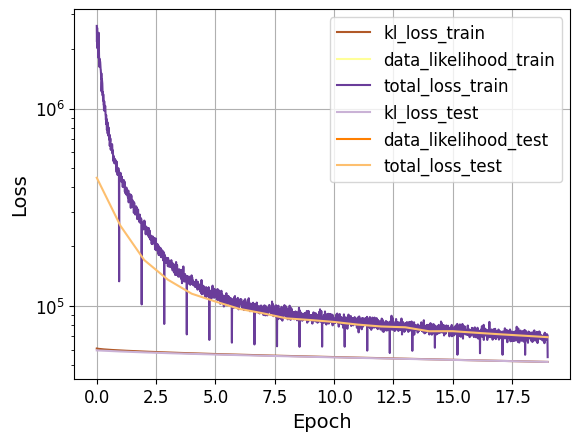

key='kl_loss' [51942.828125, 51940.16015625, 51937.4921875, 51934.81640625, 51932.15234375]
key='data_likelihood' [-163.528564453125, -148.8640899658203, -165.3061981201172, -129.89898681640625, -25.374832153320312]
key='total_loss' [71106.328125, 69385.171875, 71309.3046875, 67157.3515625, 54905.765625]


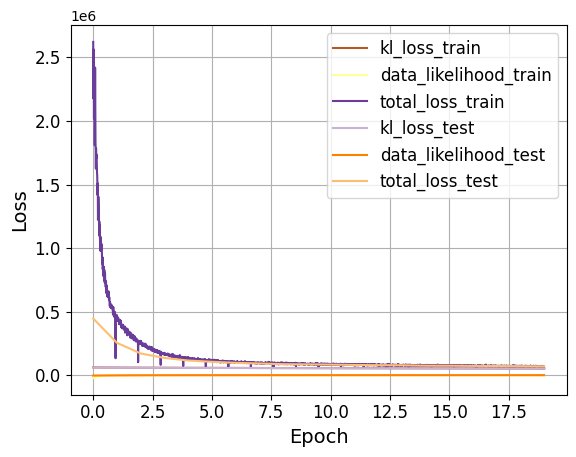

End of the training


In [9]:
%load_ext autoreload
%autoreload 2

import bayess
import bayess.nn as bnn
import torch.nn as nn
import bayess.resulting_types
from bayess.training import train_model

model_dimentions = [28 * 28, 1024, 1024, 10]
epochs = 20
n_samples = 8

return_type = bayess.resulting_types.KLLossModelOutput

model = bnn.BayessMLP(return_type, model_dimentions)

model = nn.Sequential(
      nn.Flatten(),
      model
)

data_loss = nn.CrossEntropyLoss(reduction="sum")
M = len(train_dataset)/batch_size
loss = bnn.KLLoss(data_loss= data_loss, beta = M)


opt = torch.optim.Adam(model.parameters()) #, lr = 0.01) #, lr=0.001)

train_losses, test_losses = train_model(model,loss = loss, device = device, train_loader=trainloader, n_samples = n_samples,
                                test_loader=valloader, epochs=epochs,
            optimizer= opt, loss_key= 'total_loss', visualize_samples=True, logscale_y= True)

In [10]:
from torch.nn import functional as F
items = []
model_tmp = model.to("cpu")
for layer  in model_tmp[1].net:
    if isinstance(layer, bnn.BayessLinear):
        P_div = layer.weight_mu.detach().abs() / F.softplus(layer.weight_sigma.detach(), beta = 1, threshold = 20)
        P_div = P_div.flatten().numpy() 
        items.append(P_div)
        P_div = layer.bias_mu.detach().abs() / F.softplus(layer.bias_mu.detach(), beta = 1, threshold = 20)
        P_div = P_div.flatten().numpy() 
        items.append(P_div)

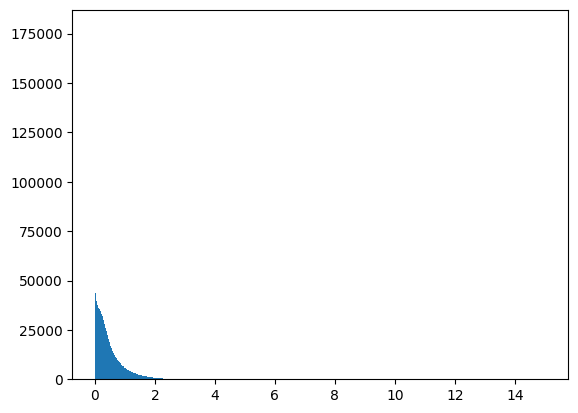

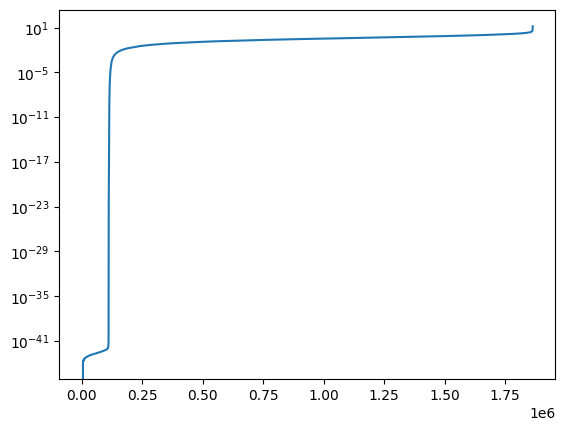

In [11]:
import numpy as np
import matplotlib.pyplot as plt
it = np.concatenate(items)
plt.hist(it, bins = 1100)
plt.show()
plt.plot(sorted(it))
plt.yscale("log")

In [12]:
st_dct = model.state_dict()
torch.save(st_dct, "200_epoch_model.pt")

In [21]:
from bayess.nn.net import MLP
def BayessMLP2MLP(model, threshold):
    """
    zeroing partiton states how match parameters will be set to 0
    """
    model_new = MLP(model.dimentions)
    state_dict = {}
    bayess_sd = model.state_dict()
    for key in model_new.state_dict().keys():        
        key_mu = key + "_mu"
        key_sigma = key + "_sigma"        

        weights = bayess_sd[key_mu].detach().clone()
        
        sigma_detach = torch.zeros_like(bayess_sd[key_sigma]).detach()
        sigma_detach = F.softplus(sigma_detach, beta = 1, threshold = 20)
        weights = weights * ((weights.abs()/sigma_detach) > threshold)
        
        state_dict[key] = weights.T
    model_new.load_state_dict(state_dict=state_dict)
    return model_new

    

In [22]:
xt, yt = [], []
for i in range(1000):
    x,y = test_dataset[i]
    xt.append(x)
    yt.append(y)
xt = torch.stack(xt, )
yt = torch.stack(yt)
xt.shape

torch.Size([1000, 1, 28, 28])

In [23]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

q_s = np.linspace(0.01, 0.99, 40)
accs = []
for q in q_s:
    val = float(np.quantile(it, q))
    
    model_bias = model[1]
    model_unb = BayessMLP2MLP(model_bias, val)
    model_unb = nn.Sequential(
            nn.Flatten(),
            model_unb
    )
    acc = (model_unb(xt).argmax(1) == yt).float().mean()
    accs.append(acc)
    print(f"{q=}  params: {pytorch_total_params * (1 - q)}:  {val=}  : {acc=}")

/tmp/ipykernel_79128/3038484683.py:19: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  state_dict[key] = weights.T


q=np.float64(0.01)  params: 3690106.2:  val=6.866362475191604e-44  : acc=tensor(0.9350)
q=np.float64(0.03512820512820513)  params: 3596443.8307692306:  val=2.6064151436441598e-43  : acc=tensor(0.9350)
q=np.float64(0.06025641025641026)  params: 3502781.4615384615:  val=2.230163846495925e-15  : acc=tensor(0.9350)
q=np.float64(0.08538461538461538)  params: 3409119.0923076924:  val=0.008121545426547527  : acc=tensor(0.9350)
q=np.float64(0.1105128205128205)  params: 3315456.723076923:  val=0.022183289751410484  : acc=tensor(0.9360)
q=np.float64(0.13564102564102565)  params: 3221794.3538461537:  val=0.03753418102860451  : acc=tensor(0.9350)
q=np.float64(0.16076923076923078)  params: 3128131.9846153846:  val=0.053478773683309555  : acc=tensor(0.9340)
q=np.float64(0.1858974358974359)  params: 3034469.6153846155:  val=0.0700334683060646  : acc=tensor(0.9370)
q=np.float64(0.21102564102564103)  params: 2940807.246153846:  val=0.08709468692541122  : acc=tensor(0.9350)
q=np.float64(0.23615384615384

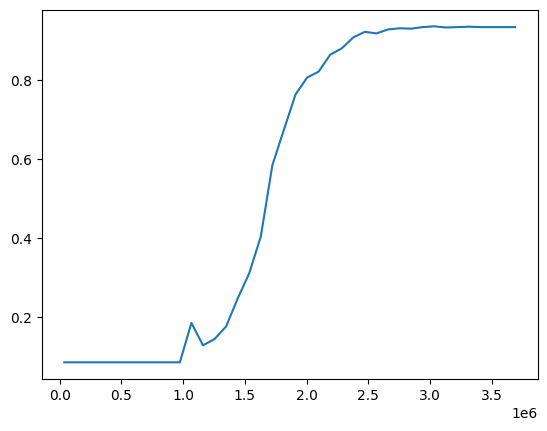

In [24]:
to = 0
plt.plot((1-q_s[to:]) * pytorch_total_params, accs[to:])

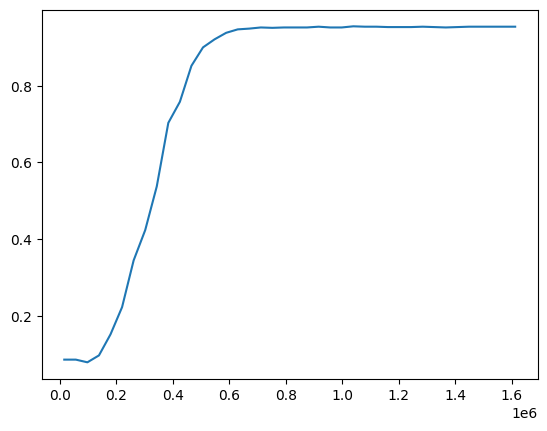

In [ ]:
to = 0
plt.plot((1-q_s[to:]) * pytorch_total_params, accs[to:])

In [2]:
from torch.distributions import normal
import torch

In [3]:
n = 10
loc = torch.rand((n,n), requires_grad= True)
scale = torch.exp(torch.rand((n,n), requires_grad=True))
distr = normal.Normal(loc=loc, scale=scale)

In [5]:
import time
 

a = distr.rsample()
a.sum().backward()
a.grad_fn

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [142]:
# Construct Gaussian Mixture Model in 1D consisting of 5 equally
# weighted normal distributions
import torch.distributions as D
MixtureSameFamily = D.MixtureSameFamily
mix = D.Categorical(torch.ones(5,))
comp = D.Normal(torch.randn(5,), torch.rand(5,))
gmm = MixtureSameFamily(mix, comp)

# Construct Gaussian Mixture Model in 2D consisting of 5 equally
# weighted bivariate normal distributions
mix = D.Categorical(torch.ones(2))
comp = D.Independent(D.Normal(
         torch.randn(2, 3), torch.rand(2, 3)), 1)
gmm = MixtureSameFamily(mix, comp)
mix.sample(), gmm.sample()

(tensor(1), tensor([-2.1213, -2.3692,  0.0902]))

In [117]:
mix.sample()

tensor([0, 0, 0, 1, 0])

In [145]:
scales = torch.zeros((2,3))
scales[0] = 1
scales[1] = 3
scales

tensor([[1., 1., 1.],
        [3., 3., 3.]])

In [170]:
from typing import Dict, Tuple, Any
import numpy as np
import torch
import torch.distributions as td
from abc import abstractmethod
from typing import TypeVar, Generic
from dataclasses import dataclass

from torch.nn.modules import Module

@dataclass
class InitargsHandler:
    prior_initargs: Dict[str, nn.Parameter]
    posterior_initargs: Dict[str, nn.Parameter]


DistributionType = TypeVar("DistributionType", bound=td.distribution.Distribution)

class ReparamNormal(td.Normal):
    def __init__(self, loc: torch.Tensor, scale: torch.Tensor, validate_args=None):
        self.loc, self._scale = loc, scale
        batch_shape = self.loc.size()
        td.Normal.__base__.__init__(self, batch_shape, validate_args=validate_args)

    @property
    def scale(self):
        return F.softplus(self._scale)
    
    
class BasePriorPosteriorReparam(Generic[DistributionType]):
    PRIOR: DistributionType
    POSTERIOR: DistributionType

    @classmethod
    def factory(cls, *args, **kwargs):
        """
        this function allows to get basic factory for class instances
        """

        def f(parameter_name, model, shape):
            return cls(parameter_name, model, shape,*args, **kwargs)
        return f
    
    def __init__(self, 
                parameter_name: str, 
                model: nn.Module, 
                shape, 
                *args, **kwargs) -> None:

        initargs: InitargsHandler = self.get_initargs(shape)

        self.prior: self.PRIOR = self.PRIOR(**initargs.prior_initargs)
        self.posterior: self.PRIOR = self.POSTERIOR(**initargs.posterior_initargs)

        # чтобы параметры появились в model.parameters
        # наверное это не совсем хорошо, можно просто возвращать список параметров пользователю в модель 
        for name, val in initargs.posterior_initargs.items():
            if isinstance(val, nn.Parameter):
                full_name = f"{parameter_name}_{name}"
                model.register_parameter(full_name, val)
            
        assert self.posterior.has_rsample == True, "posterior distribution should have '.has_rsample == True'"
    @abstractmethod
    def get_initargs(self, shape) ->InitargsHandler:
        """
        init parameters for prior and posterior initialization

        for prior parameters, set require_grad=False
        for posterior parameters, set require_grad=True
        """

    def get_kl(self,):
        """
        this function may raise 'NotImplementedError' if there is no method registered via 'register_kl()'

        More information:
        https://pytorch.org/docs/stable/distributions.html#module-torch.distributions.kl:~:text=PROPERTY%20variance-,KL%20Divergence,-torch.distributions.kl
        """
        return D.kl.kl_divergence(self.posterior, self.prior)
    
    def prior_likelihood(self, p: torch.tensor):
        return self.prior.log_prob(p)
    def posterior_likelihood(self, p: torch.tensor):
        return self.posterior.log_prob(p)
    def rsample(self):
        return self.posterior.rsample()
    
class NormalMixNormalReparam(BasePriorPosteriorReparam):
    PRIOR: td.MixtureSameFamily = td.MixtureSameFamily
    POSTERIOR: DistributionType = ReparamNormal

    @classmethod
    def factory(cls, num_classes: int = 2, 
                 class_weights: torch.Tensor = torch.tensor([0.1, 0.9]), 
                 class_scales: torch.Tensor = torch.tensor([0.001, 10.])) -> None:
        """
        Overrided factory function, since this Reparametrization needs hyperparameters for initialization
        """
        
        assert num_classes == len(class_weights) == len(class_scales)
        assert torch.isclose(sum(class_weights), torch.tensor(1.))
        assert torch.all(class_scales > 0)
        assert torch.all(class_weights > 0)

        def f(parameter_name, model, shape):
            return cls(parameter_name, model, shape, class_scales= class_scales, class_weights=class_weights)
        return f
    
    def __init__(self, parameter_name: str, model: Module, shape, class_weights, class_scales) -> None:
        self.class_weights = class_weights
        self.class_scales = class_scales
        super().__init__(parameter_name, model, shape)

    def get_initargs(self, shape) -> InitargsHandler:
        """
        init loc and scale parameters

        """
        loc = nn.Parameter(torch.rand(shape), requires_grad=True)
        scale_f = nn.Parameter(torch.randn(shape), requires_grad=True)

        posterior_params = {"loc": loc, "scale": scale_f}

        # prior params

        num_classes = len(self.class_weights)

        mix = D.Categorical(self.class_weights)

        scales = torch.rand(num_classes, *shape)
        for i in range(num_classes):
            scales[i] = self.class_scales[i]

        comp = D.Independent(D.Normal(torch.zeros(num_classes, *shape), scales), len(shape))

        prior_params = {"mixture_distribution": mix ,"component_distribution":comp}
        initargs = InitargsHandler(prior_initargs=prior_params, 
                                   posterior_initargs=posterior_params)
        return initargs            
    
class NormalNormalReparam(BasePriorPosteriorReparam):
    PRIOR: DistributionType = td.Normal
    POSTERIOR: DistributionType = ReparamNormal
    
    def get_initargs(self, shape) -> InitargsHandler:
        """
        init loc and scale parameters

        for prior parameters, set require_grad=False
        for posterior parameters, set require_grad=True
        
        """
        loc = nn.Parameter(torch.rand(shape), requires_grad=True)
        scale_f = nn.Parameter(torch.randn(shape), requires_grad=True)

        posterior_params = {"loc": loc, "scale": scale_f}

        loc_prior = nn.Parameter(torch.zeros(shape), requires_grad=False)
        scale_prior = nn.Parameter(torch.ones(shape), requires_grad=False)
        prior_params = {"loc": loc_prior, "scale": scale_prior }
        initargs = InitargsHandler(prior_initargs=prior_params, 
                                   posterior_initargs=posterior_params)
        return initargs
    

In [168]:
class BayesLinear(nn.Module):
    def __init__(self, n_in, n_out, reparam_module: BasePriorPosteriorReparam):
        super(BayesLinear, self).__init__()
        self.W: BasePriorPosteriorReparam = reparam_module("W", self, (n_in, n_out))
        self.b: BasePriorPosteriorReparam = reparam_module("b", self, (1, n_out))

    def forward(self, x):
        w = self.W.rsample()
        b = self.b.rsample()
        rez = x @ w + b

        return rez, {'prior_likelihood': self.W.prior_likelihood(w).sum(), "posterior_likelihood":  self.W.posterior_likelihood(w).sum()}
    

# reparam_handler = NormalNormalReparam.factory()
reparam_handler = NormalMixNormalReparam.factory()
net = BayesLinear(2, 3, reparam_handler)
x = torch.rand(5, 2, requires_grad=False)

optim = torch.optim.Adam(net.parameters(), lr = 0.4)

for i in range(5):
    optim.zero_grad()
    loss, out = net(x)
    loss = loss.sum()
    loss.backward()
    optim.step()
    print(loss)


tensor(12.5654, grad_fn=<SumBackward0>)
tensor(-7.9000, grad_fn=<SumBackward0>)
tensor(-5.2354, grad_fn=<SumBackward0>)
tensor(-23.7041, grad_fn=<SumBackward0>)
tensor(-33.1505, grad_fn=<SumBackward0>)


In [82]:
net.state_dict()

OrderedDict([('W_loc',
              tensor([[0.9820, 0.0726, 0.6494],
                      [0.8064, 0.4133, 0.9649]])),
             ('W_scale',
              tensor([[-0.5022, -1.0485,  0.2250],
                      [-0.4193,  2.8870, -0.3995]])),
             ('b_loc', tensor([0.9099, 0.5923, 0.7624])),
             ('b_scale', tensor([-1.2652, -1.3917, -1.7199]))])

In [10]:
from numbers import Number

isinstance(torch.tensor([2,3]), Number)

False

In [17]:
class A:
    def __init__(self) -> None:
        print("init A")

class B(A):
    def __init__(self) -> None:
        
        print("init B")

class C(B):
    def __init__(self) -> None:
        
        print("init B")

In [20]:
C.__base__

__main__.B

In [ ]:
B

In [71]:

import torch
import torch.distributions as td
import torch.nn as nn
import torch.nn.functional as F



shape = (2,3)
class Model(nn.Module):
    def __init__(self, shape):
        super(Model, self).__init__()

        # self.mu = torch.nn.parameter.Parameter(torch.rand(shape, requires_grad=True), True)
        self.register_parameter("mu", torch.nn.parameter.Parameter(torch.rand(shape, requires_grad=True), True))
        self.scale_data = torch.nn.parameter.Parameter(torch.rand(shape, requires_grad=True), True)
        print(self.scale_data)
        self.distr = ReparamNormal(loc = self.mu, scale=self.scale_data)
    def forward(self, x):
        weight = self.distr.rsample()
        rez = (x * weight).sum()
        return rez

model = Model(shape)


torch.autograd.set_detect_anomaly(True)
optim = torch.optim.Adam(model.parameters(), lr = 1)

x = torch.rand(shape, requires_grad=False)

for i in range(3):
    print(model.mu,model.scale_data, model.distr.scale, sep="\n", end="\n\n")
    optim.zero_grad()
    loss = model(x)
    loss.backward()
    optim.step()


Parameter containing:
tensor([[0.8895, 0.2050, 0.0707],
        [0.3169, 0.1843, 0.9004]], requires_grad=True)
Parameter containing:
tensor([[0.3951, 0.8230, 0.0494],
        [0.4467, 0.6799, 0.3968]], requires_grad=True)
Parameter containing:
tensor([[0.8895, 0.2050, 0.0707],
        [0.3169, 0.1843, 0.9004]], requires_grad=True)
tensor([[1.2337, 0.8009, 0.7291],
        [0.8641, 0.7896, 1.2415]], grad_fn=<SoftplusBackward0>)

Parameter containing:
tensor([[-0.6049, -0.1770, -0.9506],
        [-0.5533, -0.3201, -0.6032]], requires_grad=True)
Parameter containing:
tensor([[ 1.8895,  1.2050, -0.9293],
        [-0.6831,  1.1843, -0.0996]], requires_grad=True)
tensor([[2.0302, 1.4671, 0.3328],
        [0.4088, 1.4513, 0.6446]], grad_fn=<SoftplusBackward0>)

Parameter containing:
tensor([[-1.6049, -1.1770, -1.9506],
        [-1.5533, -1.3201, -1.6032]], requires_grad=True)
Parameter containing:
tensor([[ 2.8568,  1.9593, -1.5535],
        [-0.9171,  1.2622, -0.4551]], requires_grad=True)
t

In [36]:
model.state_dict()

OrderedDict([('mu',
              tensor([[0.8340, 0.6007, 0.7532],
                      [0.3539, 0.5770, 0.3395]])),
             ('scale_data',
              tensor([[ 0.1419, -0.9423,  0.0616],
                      [ 1.8765,  0.5960, -0.3270]]))])

In [31]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[0.2158, 0.3722, 0.6167],
        [0.3096, 0.6135, 0.5485]], requires_grad=True)
Parameter containing:
tensor([[ 0.3427,  0.2574, -0.0473],
        [ 0.4101, -0.0351, -1.6176]], requires_grad=True)


In [98]:
from typing import Any


class B:
    def __init__(self, scale) -> None:
        self._scale = scale
    
    @property
    sel
    def print(self):
        print("adsd")
    def __call__(self,) -> Any:
        print("inn")
        self.scale
a = lambda self: self.print
b = B(a)
b.scale

obj = MyClass(5)
prop = type(obj).x  # Доступ к объекту property через класс
print(prop)  # Выведет: <property object at ...>

NameError: name 'MyClass' is not defined

In [100]:
class Foo(object):
    @property
    def bar(self):
        return 0

f = Foo()



0

In [76]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[0.6849, 0.1259, 0.1455],
        [0.8630, 0.0923, 0.9254]], requires_grad=True)
Parameter containing:
tensor([[-1.0485, -0.5215,  0.5111],
        [-1.3493, -0.3862,  1.4204]], requires_grad=True)


In [41]:
data = torch.randn((2,3), requires_grad= False)
params = torch.nn.parameter.Parameter(data, True)
scale = torch.nn.functional.softplus(params)
print(scale)
data[0,0] = 100
print(scale)

tensor([[0.6042, 0.8339, 0.5346],
        [0.4134, 0.3233, 1.5400]], grad_fn=<SoftplusBackward0>)
tensor([[0.6042, 0.8339, 0.5346],
        [0.4134, 0.3233, 1.5400]], grad_fn=<SoftplusBackward0>)


In [36]:
print(type(data),type(params),type(scale) )

<class 'torch.Tensor'> <class 'torch.nn.parameter.Parameter'> <class 'torch.Tensor'>


In [ ]:
type

In [30]:
import torch
import torch.nn as nn

class GaussianModel(nn.Module):

    def __init__(self):
        super(GaussianModel, self).__init__()
        
    def forward(self, x):
        return -self.pdf.log_prob(x)

model = GaussianModel()

optimizer = torch.optim.SGD(model.parameters(), lr=0.002)
for _ in range(5):
  optimizer.zero_grad()
  nll = model(torch.tensor([3.0], requires_grad=True))
  nll.backward()
  optimizer.step()
  print('mean : ', model.state_dict()['mean'],
                 ' - Negative Loglikelihood : ', nll.item())

mean :  tensor([0.0060])  - Negative Loglikelihood :  5.418938636779785
mean :  tensor([0.0120])  - Negative Loglikelihood :  5.400956630706787
mean :  tensor([0.0180])  - Negative Loglikelihood :  5.383046627044678
mean :  tensor([0.0239])  - Negative Loglikelihood :  5.365207672119141
mean :  tensor([0.0299])  - Negative Loglikelihood :  5.347440242767334


In [106]:
class DynamicProperty:
    def __init__(self, func = None):
        # Создаем свойство с помощью property и сохраняем его в поле self.func
        # self.func = property(func)        
        pass

# Пример использования
x = 4
# Передаем функцию, которая использует переменную `x`
obj = DynamicProperty(lambda self: x + 2)
obj.__class__.func = property(lambda self: x + 2)

print(obj.func)  # Выведет 6

x = 6
print(obj.func)  # Выведет 8

6
8


In [108]:
DynamicProperty.func

In [107]:
dir(DynamicProperty)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'func']